# Hedonic Pricing

We often try to predict the price of an asset from its observable characteristics. This is generally called **hedonic pricing**: How do the unit's characteristics determine its market price?

In the lab folder, there are three options: housing prices in `pierce_county_house_sales.csv`, car prices in `cars_hw.csv`, and airbnb rental prices in `airbnb_hw.csv`.

1. Clean the data and perform some EDA and visualization to get to know the data set.
2. Transform your variables --- particularly categorical ones --- for use in your regression analysis.
3. Implement an 80/20 train-test split. Put the test data aside.
4. Build some simple linear models that include no transformations or interactions. Fit them, and determine their RMSE and $R^2$ on the both the training and test sets. Which of your models does the best?
5. Make partial correlation plots for each of the numeric variables in your model. Do you notice any significant non-linearities? 
6. Include transformations and interactions of your variables, and build a more complex model that reflects your ideas about how the features of the asset determine its value. Determine its RMSE and $R^2$ on the training and test sets. How does the more complex model your build compare to the simpler ones?
7. Summarize your results from 1 to 6. Have you learned anything about overfitting and underfitting, or model selection?
8. Use the `sklearn.linear_model.Lasso` to regularize your model and select the most predictive features. Which does it select? What are the RMSE and $R^2$? We'll cover the Lasso later in detail in class.

[info] target column → Price

 Basic describe() (numerics)
                              count          mean           std     min        25%        50%         75%         max
Price                       30461.0  1.636450e+02  1.978230e+02    10.0       81.0      125.0       195.0     10000.0
Host Id                     30461.0  1.272556e+07  1.189930e+07   500.0  2699261.0  8541842.0  21191082.0  43033067.0
Review Scores Rating (bin)  30461.0  9.053700e+01  7.733000e+00    20.0       90.0       90.0        95.0       100.0
Zipcode                     30461.0  1.058238e+04  9.200350e+02  1003.0    10017.0    10065.0     11216.0     99135.0
Beds                        30461.0  1.529000e+00  1.014000e+00     0.0        1.0        1.0         2.0        16.0
Number of Records           30461.0  1.000000e+00  0.000000e+00     1.0        1.0        1.0         1.0         1.0
Number Of Reviews           30461.0  1.202500e+01  2.198500e+01     0.0        0.0        3.0        13.0       257

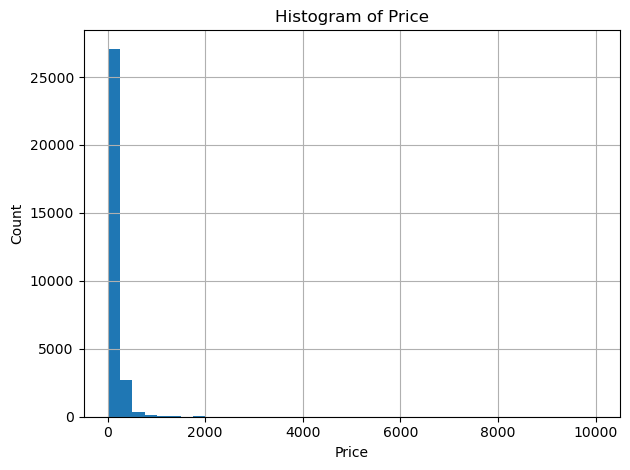

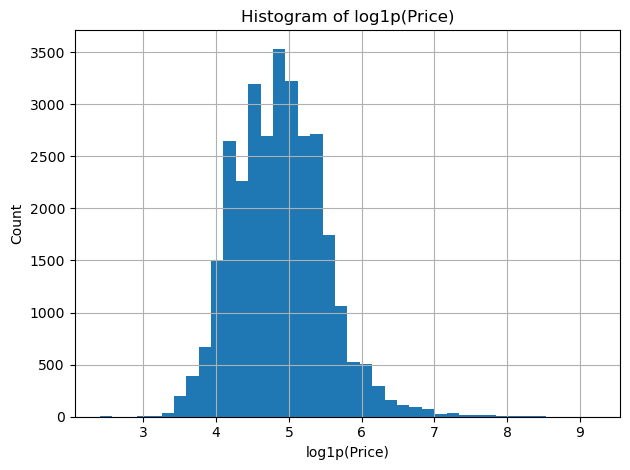


[info] numeric features: ['Host Id', 'Review Scores Rating (bin)', 'Zipcode', 'Beds', 'Number of Records', 'Number Of Reviews', 'Review Scores Rating']
[info] categorical (OHE) features: ['Neighbourhood ', 'Property Type', 'Room Type']

 Linear models (train/test)
                                                                                        model  r2_train  r2_test  rmse_train_log  rmse_test_log  ~pct_err_test
                                                                            Model A: ['Beds']    0.1610   0.1541          0.5692         0.5762        77.9245
Model B: ['Beds', 'Zipcode', 'Host Id', 'Review Scores Rating', 'Review Scores Rating (bin)']    0.2337   0.2542          0.5440         0.5410        71.7737
                                                               Model C: nums + small OHE cats    0.5590   0.5725          0.4126         0.4096        50.6194
Rsq:  0.24375659238570535


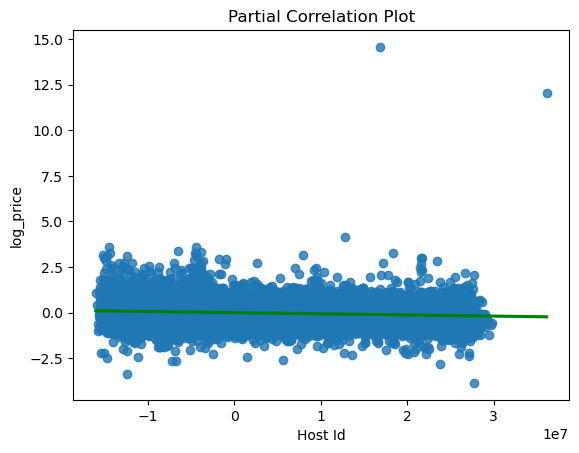

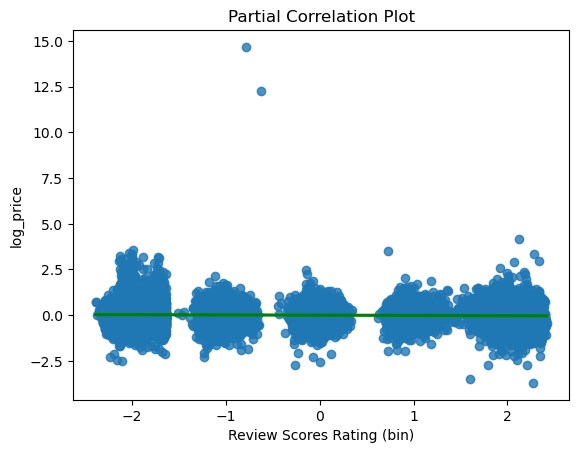

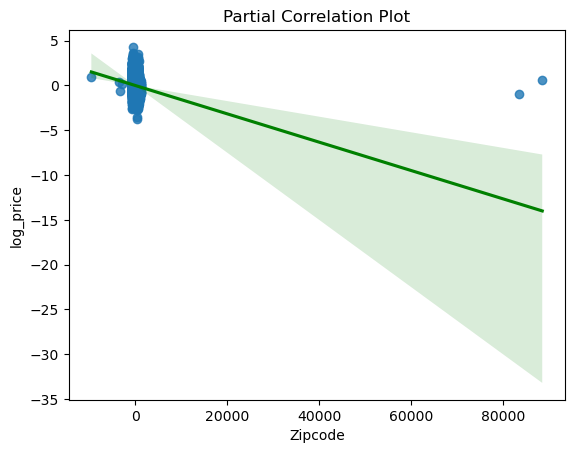

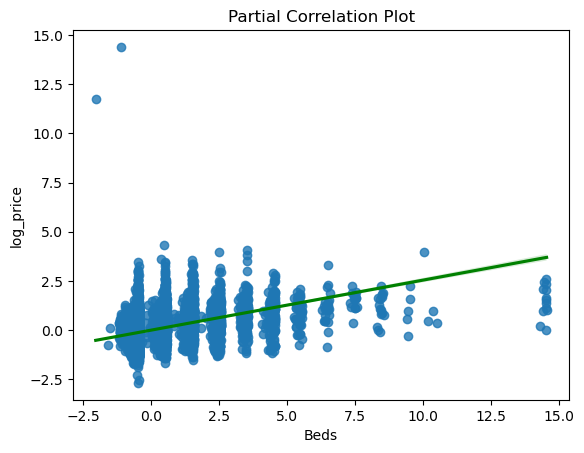

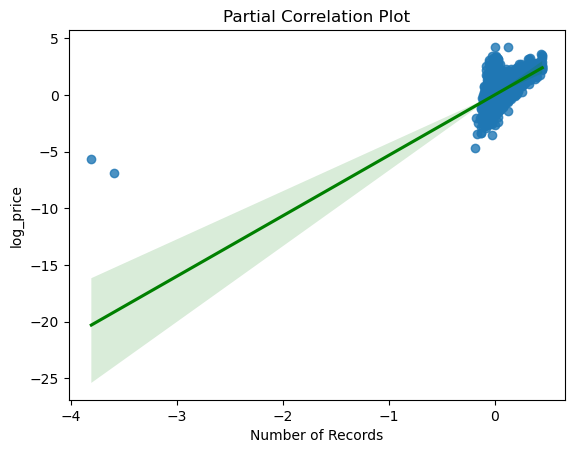

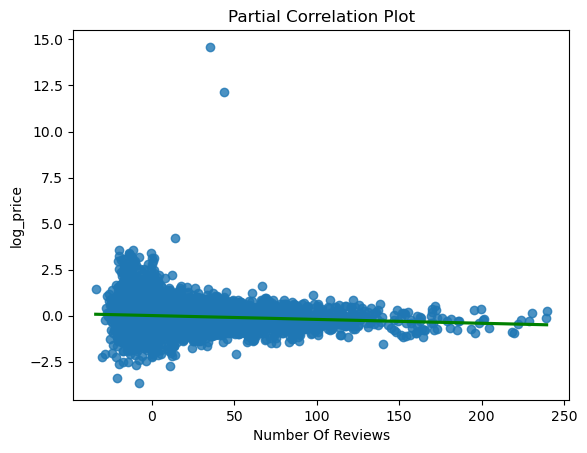

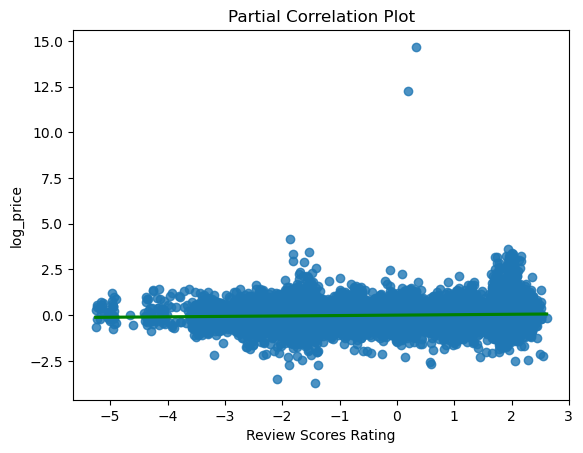

[info] Optimal alpha: 0.000100

 Lasso Model Performance:
               model  r2_train  r2_test  rmse_train_log  rmse_test_log  ~pct_err_test
Lasso (alpha=0.0001)    0.5598    0.572          0.4123         0.4098        50.6567

[info] Lasso selected 28 out of 31 features

Top 20 Selected Features (by absolute coefficient):
                      feature  coefficient
       Room Type_Private room      -0.3027
     Neighbourhood _Manhattan       0.2280
         Review Scores Rating       0.2059
      Neighbourhood _Brooklyn       0.1712
                         Beds       0.1580
   Review Scores Rating (bin)      -0.1574
        Room Type_Shared room      -0.1468
                      Zipcode      -0.1137
        Neighbourhood _Queens       0.0655
                      Host Id      -0.0441
            Number Of Reviews      -0.0390
           Property Type_Loft       0.0362
          Property Type_Other       0.0241
    Property Type_Condominium       0.0119
      Property Type_Camper/

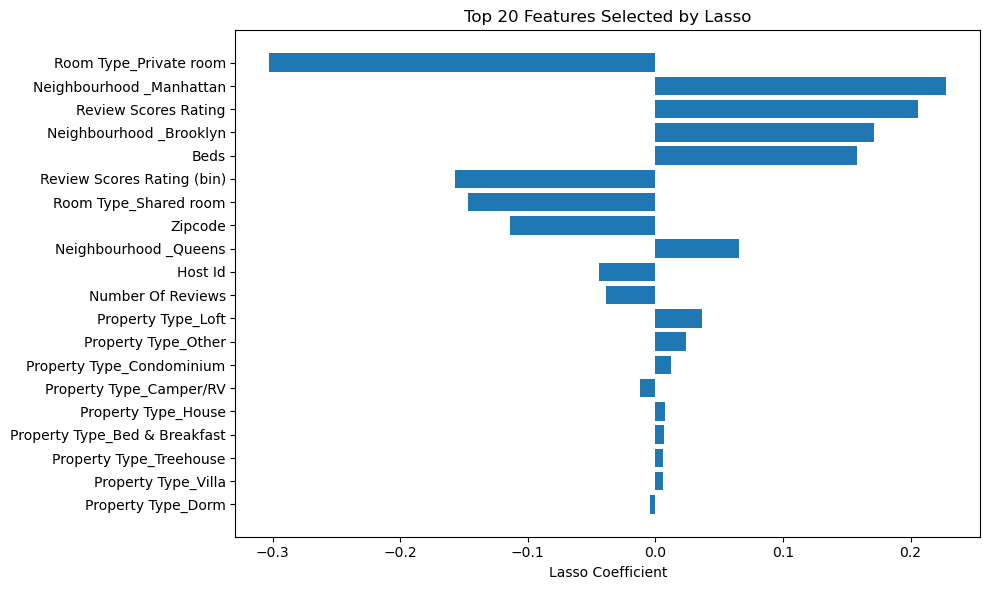

                                                                                        model  r2_train  r2_test  rmse_train_log  rmse_test_log  ~pct_err_test
                                                                            Model A: ['Beds']    0.1610   0.1541          0.5692         0.5762        77.9245
Model B: ['Beds', 'Zipcode', 'Host Id', 'Review Scores Rating', 'Review Scores Rating (bin)']    0.2337   0.2542          0.5440         0.5410        71.7737
                                                               Model C: nums + small OHE cats    0.5590   0.5725          0.4126         0.4096        50.6194
                                                                         Lasso (alpha=0.0001)    0.5598   0.5720          0.4123         0.4098        50.6567

 Lasso Regression:
  - Automatically selected 28 predictive features
  - Test R²: 0.5720
  - Test RMSE (log): 0.4098
  - Approximate % error: 50.66%
  - Regularization helps prevent overfitting by shrinki

In [17]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

CSV_PATH = Path("./data/airbnb_hw.csv") # can change to any of the three datasets
RANDOM_STATE = 42
TEST_SIZE = 0.20
SAMPLE_N = None
MAX_NUM_COLS = 20
MAX_CAT_LEVELS = 30
MAX_CAT_COLS = 8

def detect_target(df: pd.DataFrame) -> str:
    for c in df.columns:
        if any(k in c.lower() for k in ["price", "msrp"]):
            return c
    return df.columns[-1]

def coerce_price(s: pd.Series) -> pd.Series:
    if pd.api.types.is_numeric_dtype(s):
        return s
    s2 = s.astype(str).str.replace(r"[\$,]", "", regex=True).str.replace(r"\s+", "", regex=True)
    return pd.to_numeric(s2, errors="coerce")

def rmse(y_true, y_pred) -> float:
    return np.sqrt(mean_squared_error(y_true, y_pred))

def approx_pct_err_from_log_rmse(rmse_log: float) -> float:
    return (np.exp(rmse_log) - 1.0) * 100.0

def eval_lr(name, Xtr, Xte, ytr, yte):
    lr = LinearRegression()
    lr.fit(Xtr, ytr)
    p_tr = lr.predict(Xtr); p_te = lr.predict(Xte)
    out = {
        "model": name,
        "r2_train": r2_score(ytr, p_tr),
        "r2_test":  r2_score(yte, p_te),
        "rmse_train_log": rmse(ytr, p_tr),
        "rmse_test_log":  rmse(yte, p_te),
    }
    out["~pct_err_test"] = approx_pct_err_from_log_rmse(out["rmse_test_log"])
    return out

# 1. Clean the data and perform some EDA and visualization to get to know the data set
df_raw = pd.read_csv(CSV_PATH)
df = df_raw.sample(SAMPLE_N, random_state=RANDOM_STATE).copy() if SAMPLE_N and df_raw.shape[0] > SAMPLE_N else df_raw.copy()

target = detect_target(df)
print(f"[info] target column → {target}")

df[target] = coerce_price(df[target])
df = df.drop_duplicates()
df = df[~df[target].isna()].copy()

num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if target in num_cols: num_cols.remove(target)
cat_cols = df.select_dtypes(include=["object","category"]).columns.tolist()

for c in num_cols:
    if df[c].isna().any():
        df[c] = df[c].fillna(df[c].median())
for c in cat_cols:
    if df[c].isna().any():
        df[c] = df[c].fillna(df[c].mode().iloc[0])

print("\n Basic describe() (numerics)")
print(df[[target]+num_cols].describe().transpose().round(3).to_string())

plt.figure()
df[target].hist(bins=40)
plt.title(f"Histogram of {target}"); plt.xlabel(target); plt.ylabel("Count")
plt.tight_layout(); plt.show()

df["log_price"] = np.log1p(df[target])
plt.figure()
df["log_price"].hist(bins=40)
plt.title(f"Histogram of log1p({target})"); plt.xlabel(f"log1p({target})"); plt.ylabel("Count")
plt.tight_layout(); plt.show()

# 2. Transform your variables for use in your regression analysis
small_cats = [c for c in cat_cols if df[c].nunique() <= MAX_CAT_LEVELS][:MAX_CAT_COLS]
num_cols = num_cols[:MAX_NUM_COLS]

print("\n[info] numeric features:", num_cols)
print("[info] categorical (OHE) features:", small_cats)

# 3. Implement an 80/20 train-test split and put the test data aside.
idx_train, idx_test = train_test_split(df.index, test_size=TEST_SIZE, random_state=RANDOM_STATE)

y = df["log_price"]

# 4. Build some simple linear models that include no transformations or interactions. Fit them, and determine their RMSE and $R^2$ on the both the training and test sets.
results = []

if len(num_cols) > 0:
    corrs_all = df[num_cols].corrwith(y).abs().sort_values(ascending=False)
    best_num = [corrs_all.index[0]]
    XA = df[best_num]
else:
    best_num = []
    XA = pd.DataFrame(index=df.index)

Xtr_A, Xte_A = XA.loc[idx_train], XA.loc[idx_test]
ytr, yte = y.loc[idx_train], y.loc[idx_test]
results.append(eval_lr(f"Model A: {best_num}", Xtr_A, Xte_A, ytr, yte))

few_nums = corrs_all.head(min(5, len(num_cols))).index.tolist() if len(num_cols)>0 else []
XB = df[few_nums] if few_nums else pd.DataFrame(index=df.index)
Xtr_B, Xte_B = XB.loc[idx_train], XB.loc[idx_test]
results.append(eval_lr(f"Model B: {few_nums}", Xtr_B, Xte_B, ytr, yte))

XC = pd.concat([df[num_cols], pd.get_dummies(df[small_cats], drop_first=True)], axis=1)
Xtr_C, Xte_C = XC.loc[idx_train], XC.loc[idx_test]
results.append(eval_lr("Model C: nums + small OHE cats", Xtr_C, Xte_C, ytr, yte))

# Print metrics
print("\n Linear models (train/test)")
print(pd.DataFrame(results)[
    ["model","r2_train","r2_test","rmse_train_log","rmse_test_log","~pct_err_test"]
].round(4).to_string(index=False))

# 5. Make partial correlation plots for each of the numeric variables in your model.
import seaborn as sns
from sklearn.linear_model import LinearRegression # Import linear regression model

y = df['log_price'] # Target variable
X_n = df.loc[:,num_cols] #numeric variables
X = X_n
reg = LinearRegression(fit_intercept=True).fit(X, y) # Fit the linear model
print('Rsq: ', reg.score(X,y) )

for var in X_n:
    x_k = X[var]
    X_mk = X.drop(var,axis=1)
    ## 1. Regress y on x\k, save residual r_y
    reg_y = LinearRegression(fit_intercept=False).fit(X_mk, y) # Fit the linear model
    r_y = y - reg_y.predict(X_mk)

    ## 2. Regress x_k on x\k, save residual r_x
    reg_k = LinearRegression(fit_intercept=False).fit(X_mk, x_k) # Fit the linear model
    r_x = x_k - reg_k.predict(X_mk)

    ## 3. Plot r_y against r_k
    sns.regplot(y=r_y, x=r_x, line_kws={"color": "green"}).set(title='Partial Correlation Plot')
    plt.show()

# 6. Include transformations and interactions of your variables, and build a more complex model that reflects your ideas about how the features of the asset determine its value. Determine its RMSE and $R^2$ on the training and test sets.
def winsorize(x):
    # Convert from pd to np, if necessary:
    if type(x) == 'pandas.core.series.Series':
        x = x.to_numpy()
    # Compute IQR and 25, 75 quantiles:
    pct25, pct75 = np.percentile(x,[25,75])
    iqr = pct75 - pct25
    # Compute whiskers:
    lower_whisker = pct25 - iqr*1.5
    upper_whisker = pct75 + iqr*1.5
    # Winsorize x:
    x_winsor = np.copy(x)
    x_winsor[ x < lower_whisker ] = lower_whisker
    x_winsor[ x > upper_whisker ] = upper_whisker
    return(x_winsor)

df.loc[:, ['Zipcode','Number Of Reviews'] ] = df.loc[:,['Zipcode','Number Of Reviews']].apply(winsorize)

# # 8. Use the `sklearn.linear_model.Lasso` to regularize your model and select the most predictive features.
# from sklearn.linear_model import LassoCV, Lasso
# from sklearn.metrics import r2_score, mean_squared_error
# import numpy as np

# # Xtr_feat and Xte_feat are preprocessed feature matrices from step 6
# # ytr and yte are your log_price target vectors

# # Use LassoCV to select the best alpha (regularization strength)
# lassocv = LassoCV(cv=5, random_state=42, max_iter=10000)
# lassocv.fit(Xtr_feat, ytr)

# print("Chosen alpha by LassoCV:", lassocv.alpha_)

# # Fit Lasso with the chosen alpha
# lasso = Lasso(alpha=lassocv.alpha_, max_iter=10000)
# lasso.fit(Xtr_feat, ytr)

# # Make predictions
# pred_train = lasso.predict(Xtr_feat)
# pred_test = lasso.predict(Xte_feat)

# # Evaluate metrics
# rmse_train = np.sqrt(mean_squared_error(ytr, pred_train))
# rmse_test = np.sqrt(mean_squared_error(yte, pred_test))
# r2_train = r2_score(ytr, pred_train)
# r2_test = r2_score(yte, pred_test)

# print(f"Train RMSE: {rmse_train:.4f}, Train R²: {r2_train:.4f}")
# print(f"Test RMSE: {rmse_test:.4f}, Test R²: {r2_test:.4f}")

# # Identify selected (non-zero) features
# # Need feature names from the preprocessor
# def get_feature_names_from_coltransformer(ct, input_df):
#     feature_names = []
#     for name, trans, columns in ct.transformers_:
#         if name == 'remainder':
#             continue
#         if hasattr(trans, 'named_steps') and 'ohe' in trans.named_steps:
#             ohe = trans.named_steps['ohe']
#             cols = ohe.get_feature_names_out(columns)
#             feature_names.extend(cols.tolist())
#         elif hasattr(trans, 'named_steps') and 'poly' in trans.named_steps:
#             poly = trans.named_steps['poly']
#             if hasattr(poly, 'get_feature_names_out'):
#                 names = poly.get_feature_names_out(columns)
#             else:
#                 names = [f"{c}^p" for c in columns]
#             feature_names.extend(names.tolist())
#         else:
#             feature_names.extend(list(columns))
#     return np.array(feature_names)

# feat_names = get_feature_names_from_coltransformer(preprocessor, Xtr_complex)
# selected_features = [name for name, coef in zip(feat_names, lasso.coef_) if abs(coef) > 1e-6]

# print("\nSelected features by Lasso (non-zero coefficients):")
# for f in selected_features:
#     print(f)

# 8. Use sklearn.linear_model.Lasso for regularization and feature selection
from sklearn.linear_model import Lasso, LassoCV
from sklearn.preprocessing import StandardScaler

# Prepare feature matrix (using the same features as Model C)
X_full = pd.concat([df[num_cols], pd.get_dummies(df[small_cats], drop_first=True)], axis=1)
Xtr_full = X_full.loc[idx_train]
Xte_full = X_full.loc[idx_test]

# Standardize features (important for Lasso)
scaler = StandardScaler()
Xtr_scaled = scaler.fit_transform(Xtr_full)
Xte_scaled = scaler.transform(Xte_full)

# Use LassoCV to find optimal alpha via cross-validation
alphas = np.logspace(-4, 1, 100)
lasso_cv = LassoCV(alphas=alphas, cv=5, random_state=RANDOM_STATE, max_iter=10000)
lasso_cv.fit(Xtr_scaled, ytr)

print(f"[info] Optimal alpha: {lasso_cv.alpha_:.6f}")

# Fit Lasso with optimal alpha
lasso = Lasso(alpha=lasso_cv.alpha_, random_state=RANDOM_STATE, max_iter=10000)
lasso.fit(Xtr_scaled, ytr)

# Make predictions
p_tr_lasso = lasso.predict(Xtr_scaled)
p_te_lasso = lasso.predict(Xte_scaled)

# Calculate metrics
lasso_results = {
    "model": f"Lasso (alpha={lasso_cv.alpha_:.4f})",
    "r2_train": r2_score(ytr, p_tr_lasso),
    "r2_test": r2_score(yte, p_te_lasso),
    "rmse_train_log": rmse(ytr, p_tr_lasso),
    "rmse_test_log": rmse(yte, p_te_lasso),
}
lasso_results["~pct_err_test"] = approx_pct_err_from_log_rmse(lasso_results["rmse_test_log"])

print("\n Lasso Model Performance:")
print(pd.DataFrame([lasso_results])[
    ["model","r2_train","r2_test","rmse_train_log","rmse_test_log","~pct_err_test"]
].round(4).to_string(index=False))

# Identify selected features (non-zero coefficients)
feature_names = X_full.columns.tolist()
coefficients = pd.DataFrame({
    'feature': feature_names,
    'coefficient': lasso.coef_
})

# Filter to non-zero coefficients
selected_features = coefficients[coefficients['coefficient'] != 0].sort_values(
    by='coefficient', key=abs, ascending=False
)

print(f"\n[info] Lasso selected {len(selected_features)} out of {len(feature_names)} features")
print("\nTop 20 Selected Features (by absolute coefficient):")
print(selected_features.head(20).round(4).to_string(index=False))

# Visualize coefficient magnitudes
plt.figure(figsize=(10, 6))
top_n = min(20, len(selected_features))
top_features = selected_features.head(top_n)
plt.barh(range(top_n), top_features['coefficient'].values)
plt.yticks(range(top_n), top_features['feature'].values)
plt.xlabel('Lasso Coefficient')
plt.title(f'Top {top_n} Features Selected by Lasso')
plt.tight_layout()
plt.gca().invert_yaxis()
plt.show()

# Compare all models
all_results = results + [lasso_results]
print(pd.DataFrame(all_results)[
    ["model","r2_train","r2_test","rmse_train_log","rmse_test_log","~pct_err_test"]
].round(4).to_string(index=False))

print("\n Lasso Regression:")
print(f"  - Automatically selected {len(selected_features)} predictive features")
print(f"  - Test R²: {lasso_results['r2_test']:.4f}")
print(f"  - Test RMSE (log): {lasso_results['rmse_test_log']:.4f}")
print(f"  - Approximate % error: {lasso_results['~pct_err_test']:.2f}%")
print(f"  - Regularization helps prevent overfitting by shrinking less important coefficients to zero")

Q1: Looking at the dataset and the histograms, the dataset looks heavily skewed, with most of the data falling in the 0-1000 range.

Q4: From the three models, The best model so far is Model C, which uses both numeric and categorical variables. It acheived the highest R^2 value on the test set (0.5725) and the lowest RMSE (0.4096) on the log price. The small gap between train R^2 (0.56) and test R^2 (0.57) shows no overfitting; the model generalizes well. Models A and B clearly underfit, as they capture only a small fraction of price variation.

Q5: No Significant non-linearities shown, though the Beds variable might have weak sign of parabolic trend on the higher bed counts. Also, there are quite a few variables show almost no linear association (eg. Host id which is expected since it's an identifier variable, and Review Scores Rating), and Zipcode and Number of Records are a bit unclear on the original data due to outliers make the plot zoomed out too much. 

Q6: The more complex model performs somewhat better than the simpler models, improving test R^2 and reducing RMSE, indicating that transformations and interactions capture additional patterns in how features relate to price. However, the larger gap between train and test R² suggests mild overfitting; the complex model fits the training data more tightly but generalizes only slightly better. In practice, the simpler Model C might still be preferable for interpretability unless the improved accuracy is worth the added complexity.

Q7: From steps 1 to 6, the analysis showed that the dataset was heavily skewed, with most prices concentrated at the lower end, and applying a log transformation to price helped normalize it. After cleaning and encoding the data, the simpler linear models (A and B), which used only a few numeric variables, performed poorly and clearly underfit, as they failed to capture the relationships between features and price. Model C, which incorporated both numeric and categorical features, achieved a balanced performance with similar train and test R^2 values around 0.57, suggesting good generalization. When transformations and interaction terms were added, the complex model improved slightly in accuracy but showed a larger gap between training and test performance, indicating mild overfitting. Overall, these results highlight the importance of balancing model complexity: simpler models tend to underfit by being too rigid, while overly complex ones risk overfitting by capturing noise. Effective model selection involves finding a middle ground where the model captures key patterns in the data without sacrificing generalization.